In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
amazon_ratings=pd.read_csv("ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])

In [5]:
amazon_ratings.head()
data=amazon_ratings

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [6]:
data.shape

(180653, 4)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180653 entries, 0 to 180652
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     180653 non-null  object 
 1   productId  180652 non-null  object 
 2   Rating     180652 non-null  float64
 3   timestamp  180652 non-null  float64
dtypes: float64(2), object(2)
memory usage: 5.5+ MB


In [26]:
data.describe()

,Rating,timestamp
count,180652.000000,1.806520e+05
mean,4.020885,1.208516e+09
std,1.369213,1.515594e+08
min,1.000000,9.127296e+08
25%,4.000000,1.045613e+09
50%,5.000000,1.236211e+09
75%,5.000000,1.358122e+09
max,5.000000,1.405987e+09


In [9]:
print('Number of missing values across columns: \n',data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    1
Rating       1
timestamp    1
dtype: int64


In [10]:
no_of_rated_products_per_user = data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A231WM2Z2JL0U3    179
A5JLAU2ARJ0BO      73
A2BGZ52M908MJY     54
A25HBO5V8S8SEA     52
AT2J7H5TRZM8Z      45
Name: Rating, dtype: int64

In [11]:
no_of_rated_products_per_user.describe()

count    157740.000000
mean          1.145252
std           0.896320
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         179.000000
Name: Rating, dtype: float64

In [12]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [13]:
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      2
0.97      2
0.98      3
0.99      4
1.00    179
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

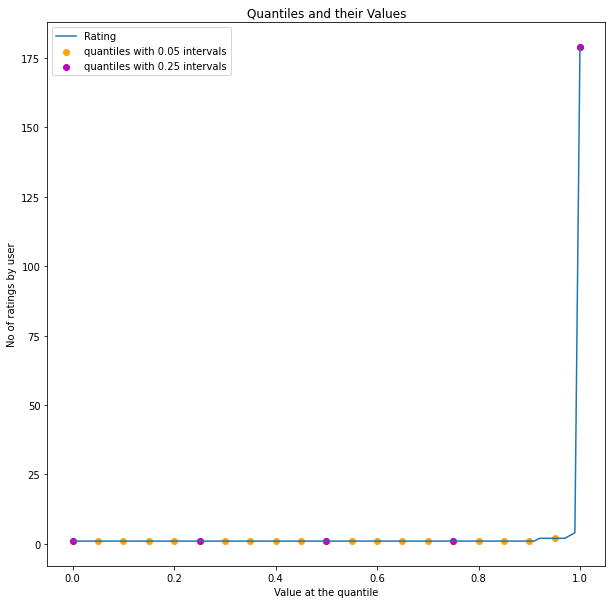

In [14]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()


In [15]:
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [16]:
popular_products = pd.DataFrame(data.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
productId,
B00004ZCJE,2547
B00001P4ZH,2075
B000065BP9,1714
B00004T8R2,1692
B00001WRSJ,1586
B000065BPB,1304
B00005N6KG,1296
B00005T3G0,1287
B00005LEN4,1107


In [17]:
data['productId'].head()

0    0132793040
1    0321732944
2    0439886341
3    0439886341
4    0439886341
Name: productId, dtype: object

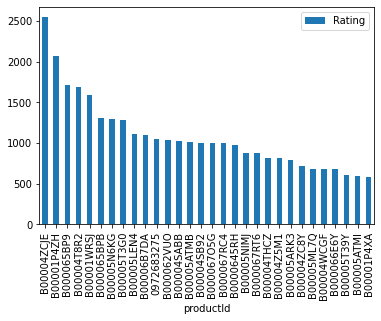

In [18]:
most_popular.head(30).plot(kind = "bar")

In [19]:
data1 = data.head(10000)

In [20]:
ratings_utility_matrix = data1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_utility_matrix.head()

productId,0132793040,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,0594033926,0594033934,0594202442,0594287995,0594296420,0594450209,0594450705,0594451647,0594477670,0594478162,0594481813,0594481902,0594482127,0594511488,0594514681,0594514789,0594549507,0594549558,0743610431,0777700018,0840017677,0879393742,089933623X,0899336795,094339676X,0970407998,0970408005,0972683275,0977703037,...,B00000J0B0,B00000J0BM,B00000J0CE,B00000J0D2,B00000J0D5,B00000J0D8,B00000J0E2,B00000J0E6,B00000J0E8,B00000J0E9,B00000J0EN,B00000J0FF,B00000J0GF,B00000J0GJ,B00000J0IS,B00000J0IT,B00000J0IU,B00000J0IV,B00000J0IX,B00000J0J0,B00000J0J1,B00000J0KX,B00000J0MF,B00000J0MS,B00000J0ND,B00000J0QI,B00000J0U2,B00000J0UE,B00000J0UP,B00000J1AG,B00000J1DN,B00000J1DT,B00000J1E6,B00000J1EC,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1ES,B00000J1EZ,B00000J1F3
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A01255851ZO1U93P8RKGE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0402564TCEO67AUZFJO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
ratings_utility_matrix.shape

(9826, 1305)

In [22]:
X = ratings_utility_matrix.T
X.head()

userId,A00766851QZZUBOVF4JFT,A01255851ZO1U93P8RKGE,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0402564TCEO67AUZFJO,A04256643L1ZMT75HVD2P,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A07865442XT0VEAVPSGX1,A0821988FXKFYX53V4QG,A085830328D6R4Z74JTJ,A099626739FNCRNHIKBCG,A100IGCRWUYAZW,A100LLXMXDZHJZ,A10121433FMMZNY18RWZ8,A1013OEQCVS6AR,A1013Q8NLCY56R,A101DJDPGK0Q46,A10285OSAM1MZK,A102IUFPXVDRB6,A102L0RVI4LHH3,A102RLOGIBBDMW,A1038957GWRBP375RU5T,A1058D8UFZL711,A105AZN9C8UAOJ,A105C374T9A12,A105R38CAPDBGU,A105ZJJNE4AFTU,A106YUCY4SVX1D,A1077JEY0CE3BB,A1079KKA0AXSL3,A107I2HYD2JZ5G,A107S4MT25VXQ5,A1088LCAS58FXN,A1089S59XSJT2T,A108EEYSHGDL6O,A108LYH0NZ9919,A108UXJTIV8XXY,A10956KAP9F1CO,...,AZJXOSW6EHYKB,AZKOO6TVQBDAF,AZKQZNA1FXKY8,AZL95QPWJDM3Y,AZM1KR1X4478H,AZM8PD2KBVXN5,AZMY6E8B52L2T,AZNMO6T8G0ZEU,AZO3DZAJ8S0D9,AZODG8OG0CETL,AZOFJX627J181,AZP1HKS4XINS0,AZPPZOYTNLEN0,AZPT44204EODM,AZPT6K5K0IVCT,AZPXDTWY5M5MQ,AZQG3BOZE5J8S,AZQJQBJ75DHMS,AZQOWHUHXMIMS,AZQQR46TEV0AJ,AZQQVI9RHJYH6,AZQZ3STMCBG5H,AZRPGTU8A7KD5,AZSUNAT0BRQDU,AZSZOO6PQKG6Z,AZT3AXKZYBY4P,AZTC7YC8PKG39,AZTC8ZV20NO1D,AZTYUD0UXIJI0,AZU626MLDSIAG,AZV9WA9MNT0FB,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXFQVG0PS3V1,AZYNQZ94U6VDB,AZYTSU42BZ7TP,AZZ77XYX8O2WE,AZZGUU97OHUF1,AZZMV5VT9W7Y8
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0132793040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0321732944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0439886341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0511189877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0
0528881469,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
X.shape
X1=X

(1305, 9826)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD


SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1305, 10)

In [27]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1305, 1305)

In [28]:
X.index[99]

'1616833734'

In [32]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1305,)

In [34]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove('1616833734') 

Recommend[0:9]

['0439886341',
 '0743610431',
 '134048160X',
 '1590744306',
 '1604550945',
 '1615527672',
 '1616855711',
 '1616873973',
 '1891747134']

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
product_descriptions = pd.read_csv('../input/home-depot-product-search-relevance/product_descriptions.csv')
product_descriptions.shape

In [ ]:
product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

In [ ]:
# product_descriptions1.iloc[:,1]

product_descriptions1["product_description"].head(10)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])
X1

In [ ]:

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [ ]:
true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)